# MuTrans script: cisplatin -> recovery 1 week -> recovery 4 weeks

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(3, 3), facecolor='white')
import matplotlib.pyplot as plt
import pyMuTrans as pm
import hdf5plugin
import gc
import seaborn as sns

datadir = "data/"

In [3]:
adata = sc.read(datadir+'exit_v2_seurat.h5ad')
adata

AnnData object with n_obs × n_vars = 12907 × 22754
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Sample', 'Barcode', 'sizeFactor', 'CMO', 'CellID', 'ID', 'Class', 'sample_id', 'description', 'Rec', 'Condition', 'Counts', 'replicate', 'sum', 'detected', 'subsets_mt_sum', 'subsets_mt_detected', 'subsets_mt_percent', 'subsets_linc_sum', 'subsets_linc_detected', 'subsets_linc_percent', 'subsets_ribo_sum', 'subsets_ribo_detected', 'subsets_ribo_percent', 'total', 'Seurat.Phase', 'Seurat.S', 'Seurat.G2M', 'Cyclone.Phase', 'Cyclone.G1', 'Cyclone.S', 'Cyclone.G2M', 'Tricycle.Phase', 'Tricycle.Position', 'nCount_SCT', 'nFeature_SCT', 'Seurat.Cycle.Score', 'snn_res.0.2', 'seurat_clusters.0.2', 'snn_res.0.4', 'seurat_clusters.0.4', 'snn_res.0.6', 'seurat_clusters.0.6', 'snn_res.0.8', 'seurat_clusters.0.8', 'snn_res.1', 'seurat_clusters.1', 'snn_res.1.2', 'seurat_clusters.1.2', 'snn_res.1.4', 'seurat_clusters.1.4', 'snn_res.1.6', 'seurat_clusters.1.6', 'snn_res.1.8', 'seurat_clusters.1.8',

In [4]:
adata.layers["raw_counts"] = adata.raw.X
adata.layers["seurat_lognorm"] = adata.X
adata.X = adata.raw.X

In [5]:
adata.obs = adata.obs[['Sample', 'Barcode', 'Class', 'sample_id', 'description', 'Rec', 'Condition', 'MES.Sig', 'ADRN.Sig', 'AMT.score']]
adata.obsm = []
adata

AnnData object with n_obs × n_vars = 12907 × 22754
    obs: 'Sample', 'Barcode', 'Class', 'sample_id', 'description', 'Rec', 'Condition', 'MES.Sig', 'ADRN.Sig', 'AMT.score'
    var: 'features'
    layers: 'raw_counts', 'seurat_lognorm'

In [6]:
# Check adata has raw counts matrix
df = pd.DataFrame.sparse.from_spmatrix(adata.X)
df.head(10)

0      1      2      3      4      5      6      7      8      9      ...  \
0    1.0    0.0    0.0    0.0    0.0    2.0    0.0    0.0    1.0    2.0  ...   
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0    0.0    0.0  ...   
2    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    2.0    2.0  ...   
3    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0  ...   
4    0.0    0.0    0.0    0.0    1.0    3.0    0.0    1.0    4.0    3.0  ...   
5    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0  ...   
6    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0    2.0  ...   
7    3.0    0.0    0.0    0.0    0.0    1.0    0.0    2.0    1.0    4.0  ...   
8    0.0    1.0    0.0    1.0    0.0    0.0    0.0    1.0    1.0    3.0  ...   
9    0.0    0.0    0.0    0.0    1.0    0.0    0.0    1.0    2.0    1.0  ...   

   22744  22745  22746  22747  22748  22749  22750  22751  22752  22753  
0    0.0    0.0    0.0    0.0    2.0    0.0    0.0    0.0    1.0    0.0  
1    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0  
2    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0  
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0  
5    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
6    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0  
7    0.0    0.0    0.0    0.0    3.0    0.0    0.0    0.0    1.0    0.0  
8    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0    0.0  
9    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0  

[10 rows x 22754 columns]

## Pre-processing

Quick QC

In [7]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # Annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars = ['mt'], percent_top = None, log1p = False, inplace = True)

Normalisation

In [8]:
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)

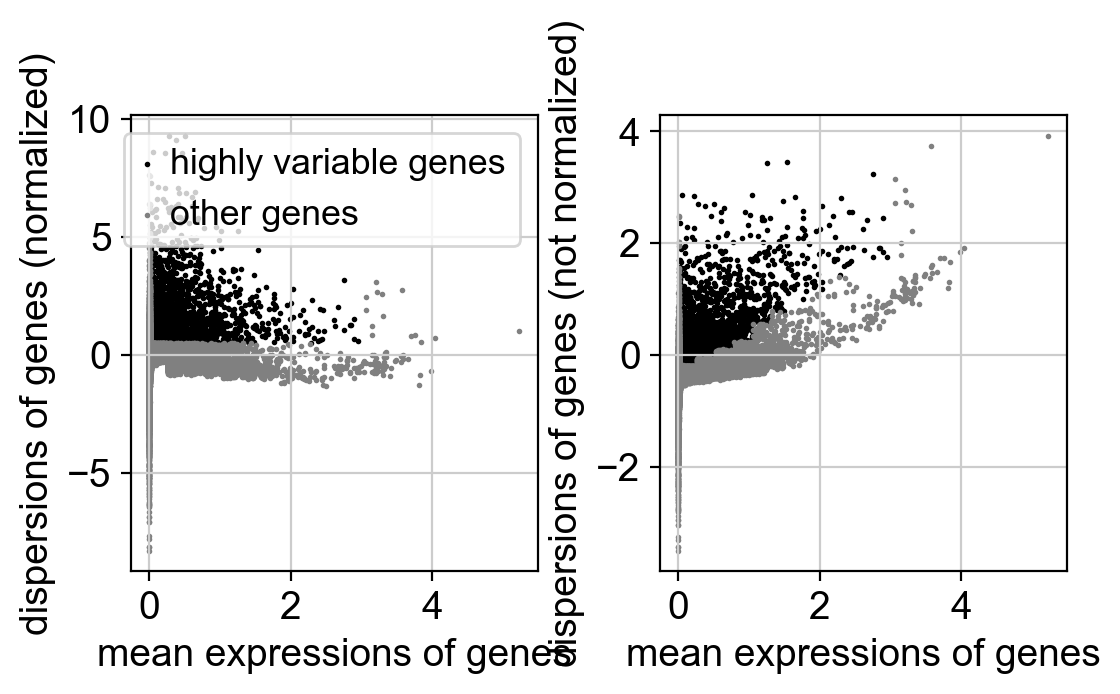

In [9]:
sc.pl.highly_variable_genes(adata)

In [10]:
# Set .raw attribute of AnnData object to the normalised and logarithmized raw gene expression
adata.raw = adata
# Filter for highly variable genes
adata = adata[:, adata.var.highly_variable]

In [11]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\anndata\_core\anndata.py:1294: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\anndata\_core\anndata.py:1294: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\anndata\_core\anndata.py:1294: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\anndata\_core\anndata.py:1294: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\anndata\_core\anndata.py:1294: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df

In [12]:
sc.pp.scale(adata, max_value=10) # Clips values exceeding sd = 10

Reduced dims

In [13]:
sc.tl.pca(adata, svd_solver = 'arpack')

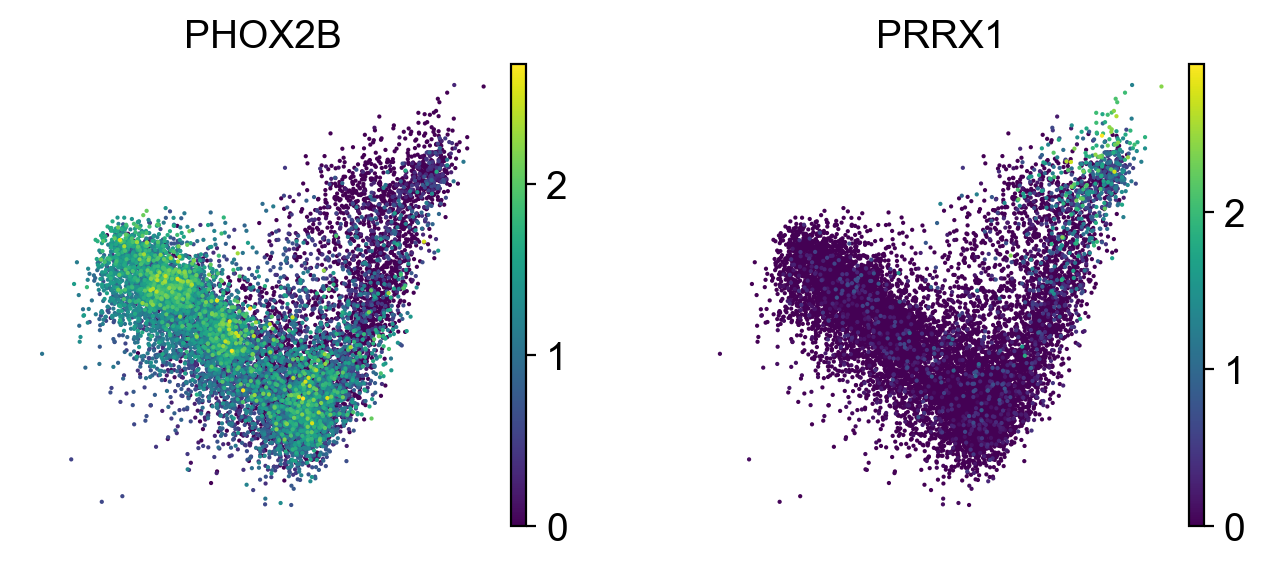

In [14]:
sc.pl.pca(adata, color = ['PHOX2B','PRRX1'])

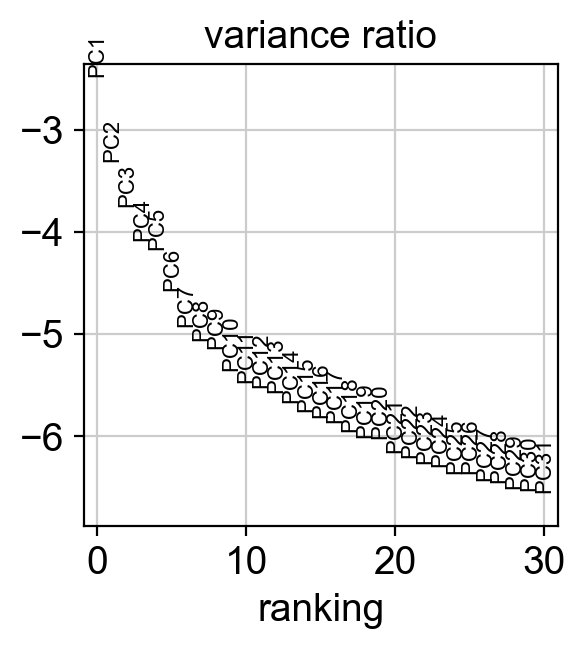

In [15]:
sc.pl.pca_variance_ratio(adata, log = True)

In [16]:
sc.pp.neighbors(adata, n_neighbors = 10, n_pcs = 40)

c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\umap\distances.py:1086: NumbaD

In [17]:
sc.tl.umap(adata)

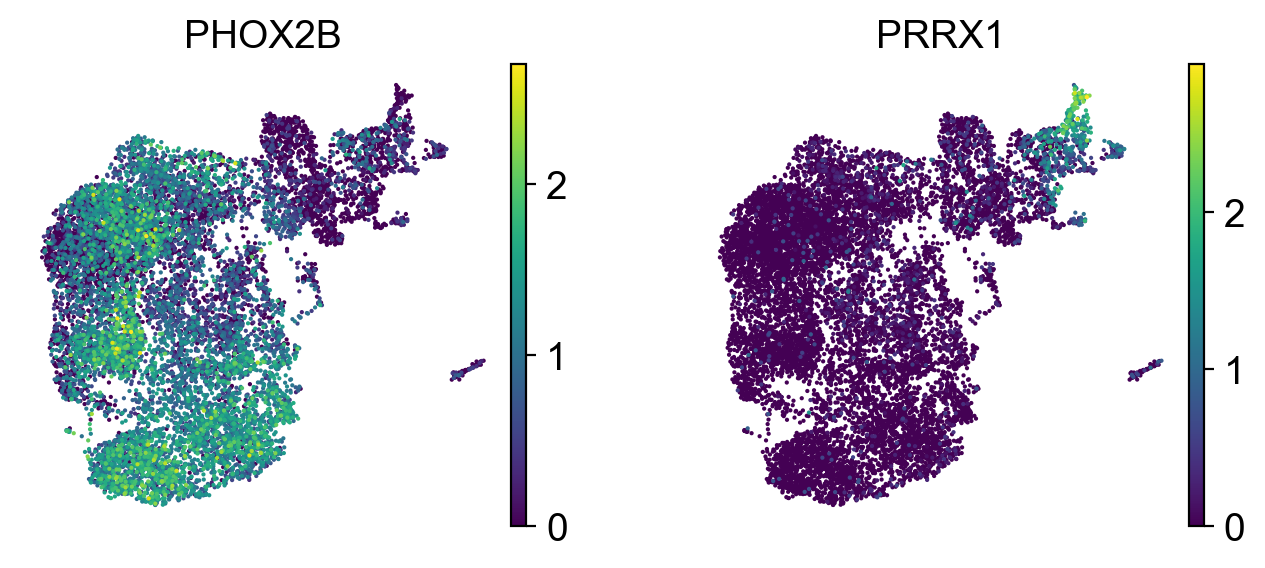

In [18]:
sc.pl.umap(adata, color = ['PHOX2B', 'PRRX1'])

Clustering

In [19]:
sc.tl.leiden(adata, resolution = 0.1)

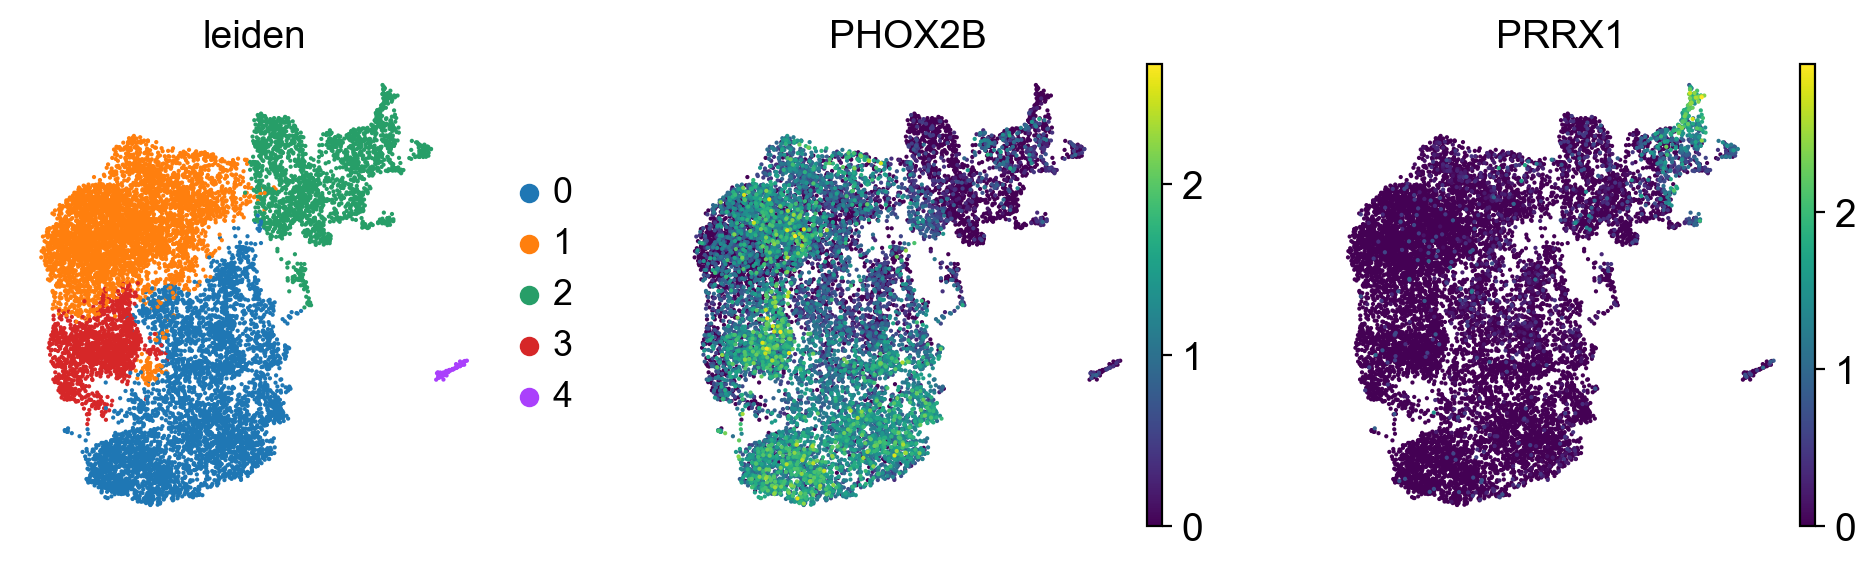

In [20]:
sc.pl.umap(adata, color = ['leiden', 'PHOX2B', 'PRRX1'])

In [21]:
adata.write_h5ad(
    datadir+"exit_v2_scanpy.h5ad",
    compression = hdf5plugin.FILTERS["zstd"]
)

Marker genes

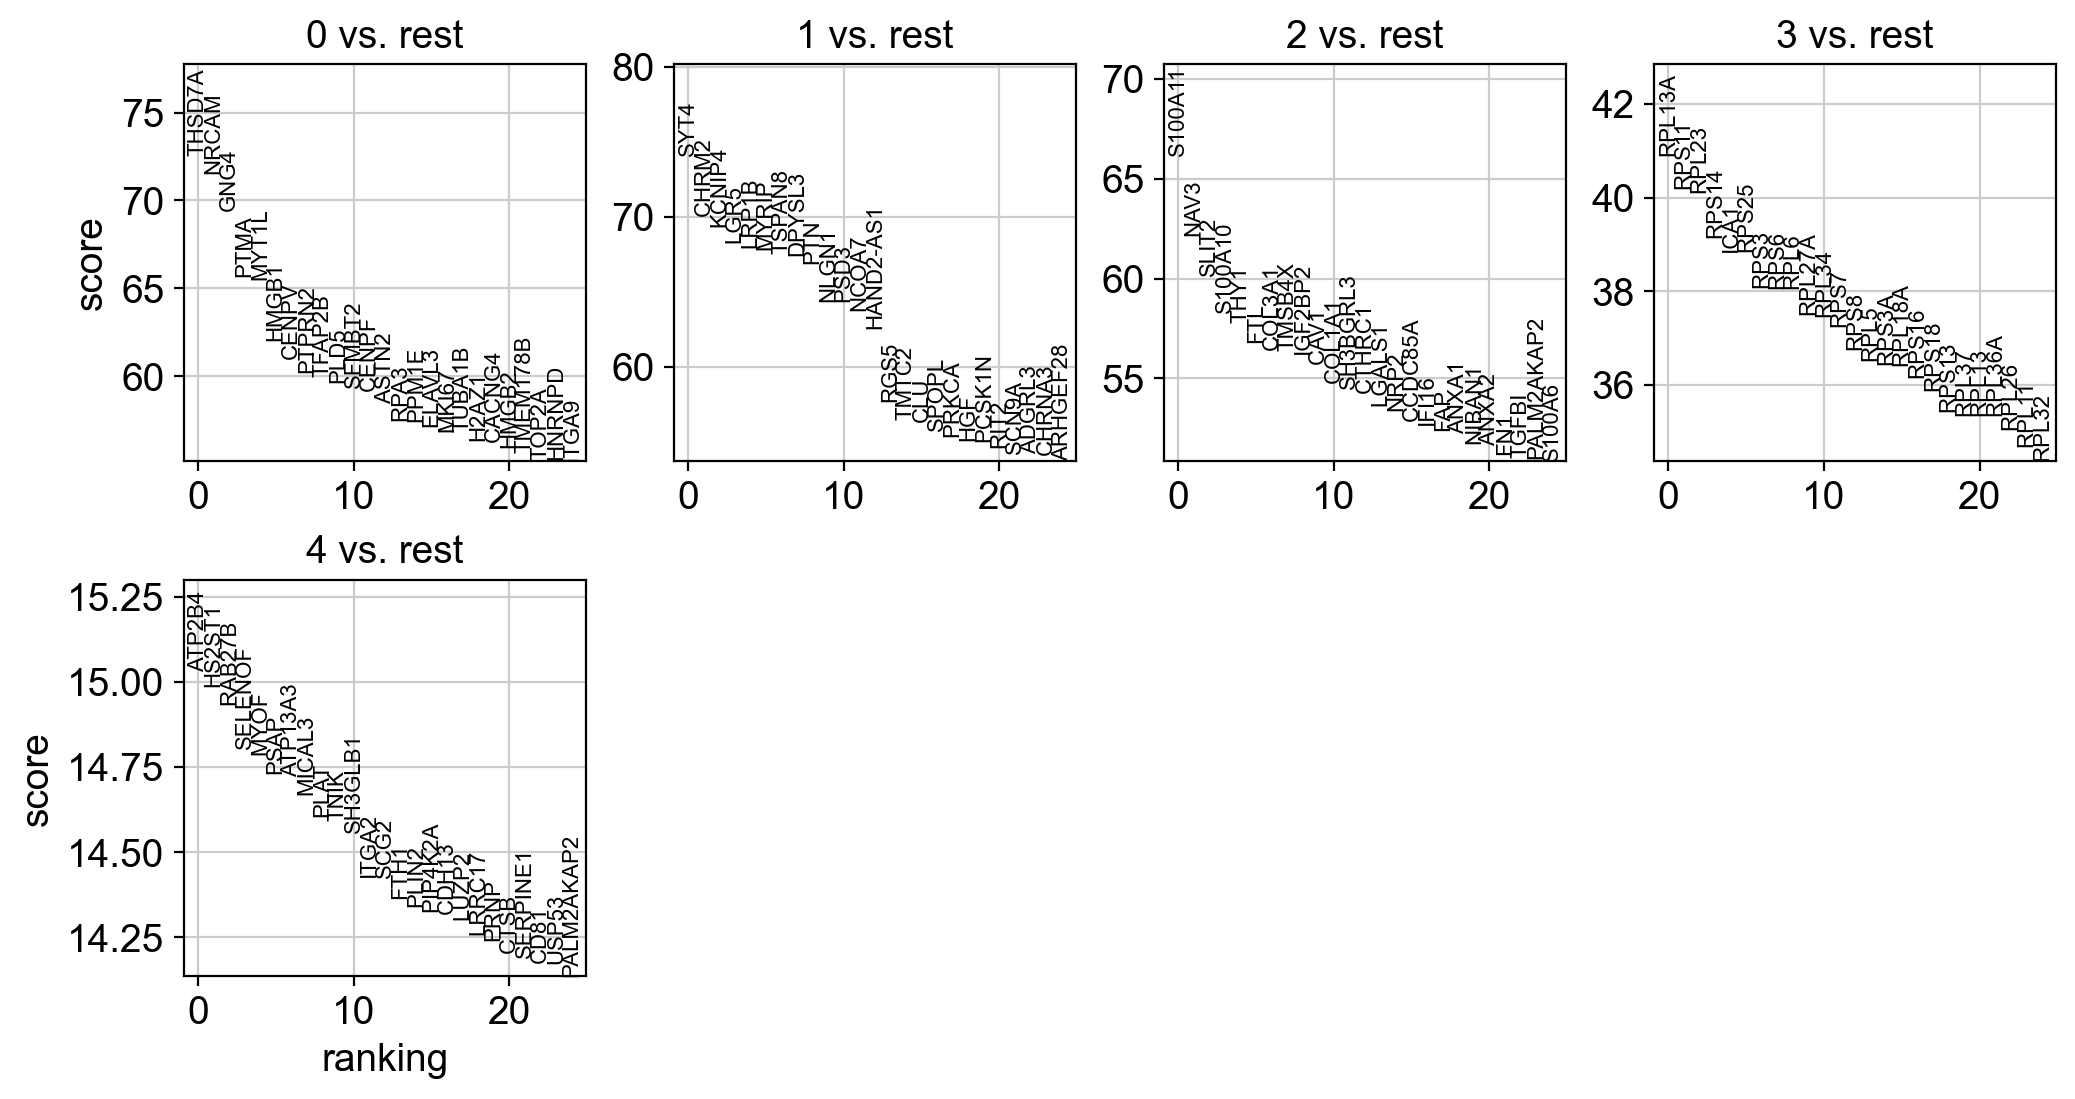

In [22]:
sc.tl.rank_genes_groups(adata, 'leiden', method = 'wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes = 25, sharey = False)

PAGA analysis

In [23]:
adata = sc.read(datadir+"exit_v2_scanpy.h5ad")

c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


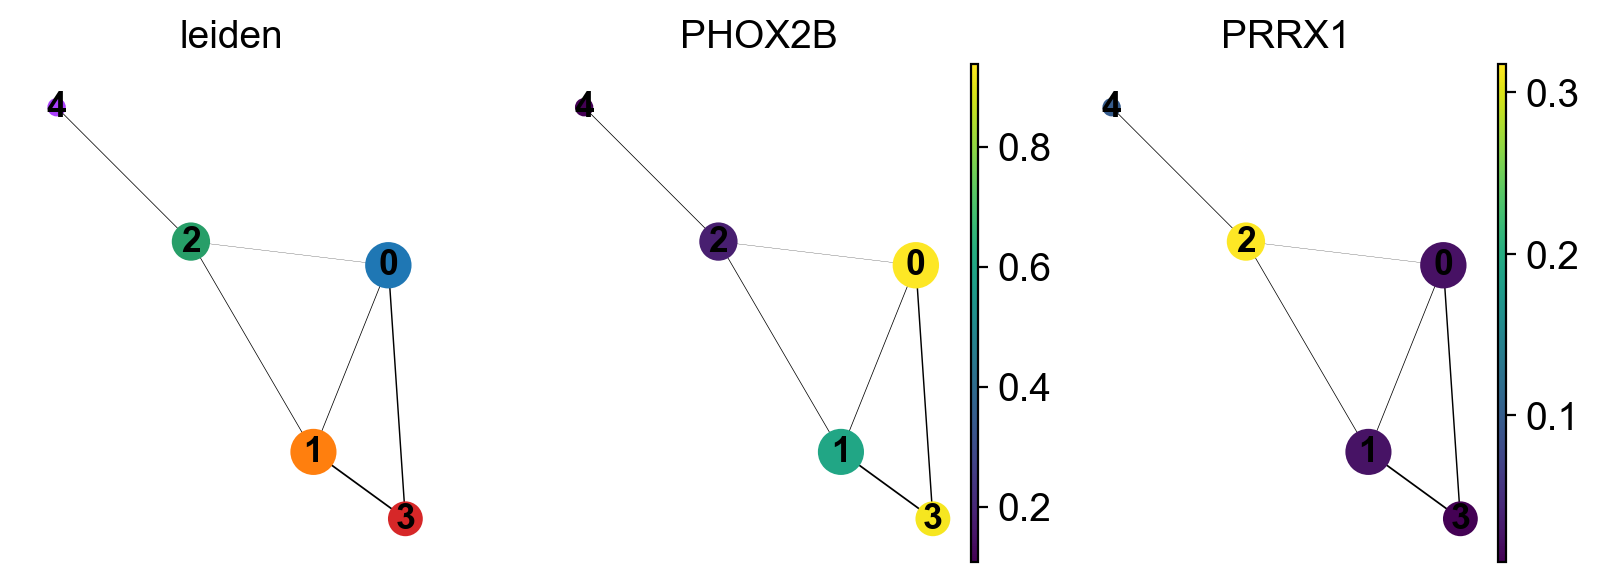

In [24]:
sc.tl.paga(adata, groups = 'leiden')
sc.pl.paga(adata, color = ['leiden', 'PHOX2B', 'PRRX1'])

## Mutrans analysis

In [25]:
sc.tl.tsne(adata, n_pcs = 30)

In [26]:
sc.pp.neighbors(adata, metric = 'cosine', n_neighbors = 60, use_rep = 'X')

In [27]:
adata.write_h5ad(
    datadir+"exit_v2_scanpy_nn.h5ad",
    compression = hdf5plugin.FILTERS["zstd"]
)

#### Start run from here

In [28]:
plotdir = "../../plots/exit_v2/"

In [29]:
adata = sc.read(datadir+"exit_v2_scanpy_nn.h5ad")

c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [30]:
gc.collect()

100802

In [31]:
par = {"choice_distance":"cosine","K_cluster":5.0,"trials":50,"weight_scale":True,"initial":"pca","reduce_large_scale":True,"reduce_num_meta_cell":1000.0} 
adata_mu = pm.dynamical_analysis(adata, par)
out = adata_mu.uns['da_out']
ind = np.argsort(np.asarray(out['perm_class']).ravel().astype(int)-1)
labels_in_meta = np.asarray(out['reduce_class']).ravel().astype(int)-1
attractor_meta = np.asarray(out['class_order']).ravel()[ind]-1
adata_mu.obs['attractor'] = [ int(attractor_meta[labels_in_meta[i]]) for i in range(len(labels_in_meta))]
entropy_meta = np.asarray(out['H']).ravel()[ind]
adata_mu.obs['entropy'] = [entropy_meta[labels_in_meta[i]] for i in range(len(labels_in_meta))]

In [32]:
adata_mu

AnnData object with n_obs × n_vars = 12907 × 2433
    obs: 'Sample', 'Barcode', 'Class', 'sample_id', 'description', 'Rec', 'Condition', 'MES.Sig', 'ADRN.Sig', 'AMT.score', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'attractor', 'entropy'
    var: 'features', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'tsne', 'umap', 'da_out', 'land'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts', 'seurat_lognorm'
    obsp: 'connectivities', 'distances'

In [33]:
np.asarray(adata_mu.uns['da_out']['mu_hat'])

array([[0.36093706],
       [0.250755  ],
       [0.22232762],
       [0.07234922],
       [0.0936311 ]])

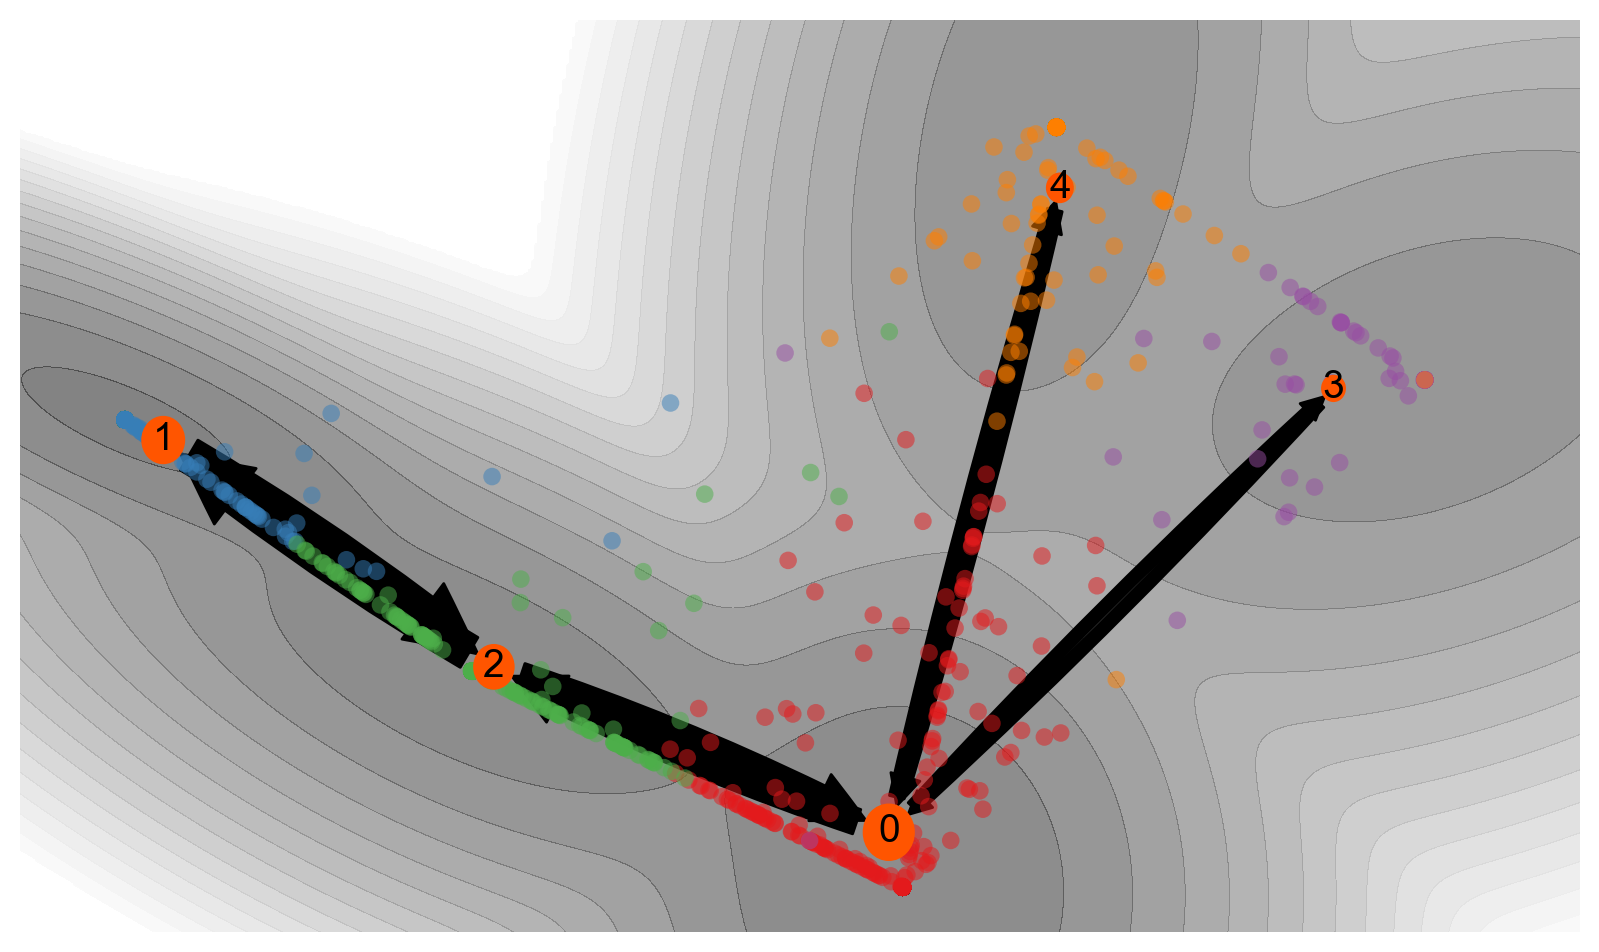

In [34]:
fig = plt.figure(figsize = (10, 6))
pm.infer_lineage(adata_mu, method = "MPFT", size_point = 40, alpha_point = 0.5, size_text = 15)
plt.savefig(plotdir+"exit_v2_mpft.pdf")
plt.savefig(plotdir+"exit_v2_mpft.png")

MPPT from 1 to 3

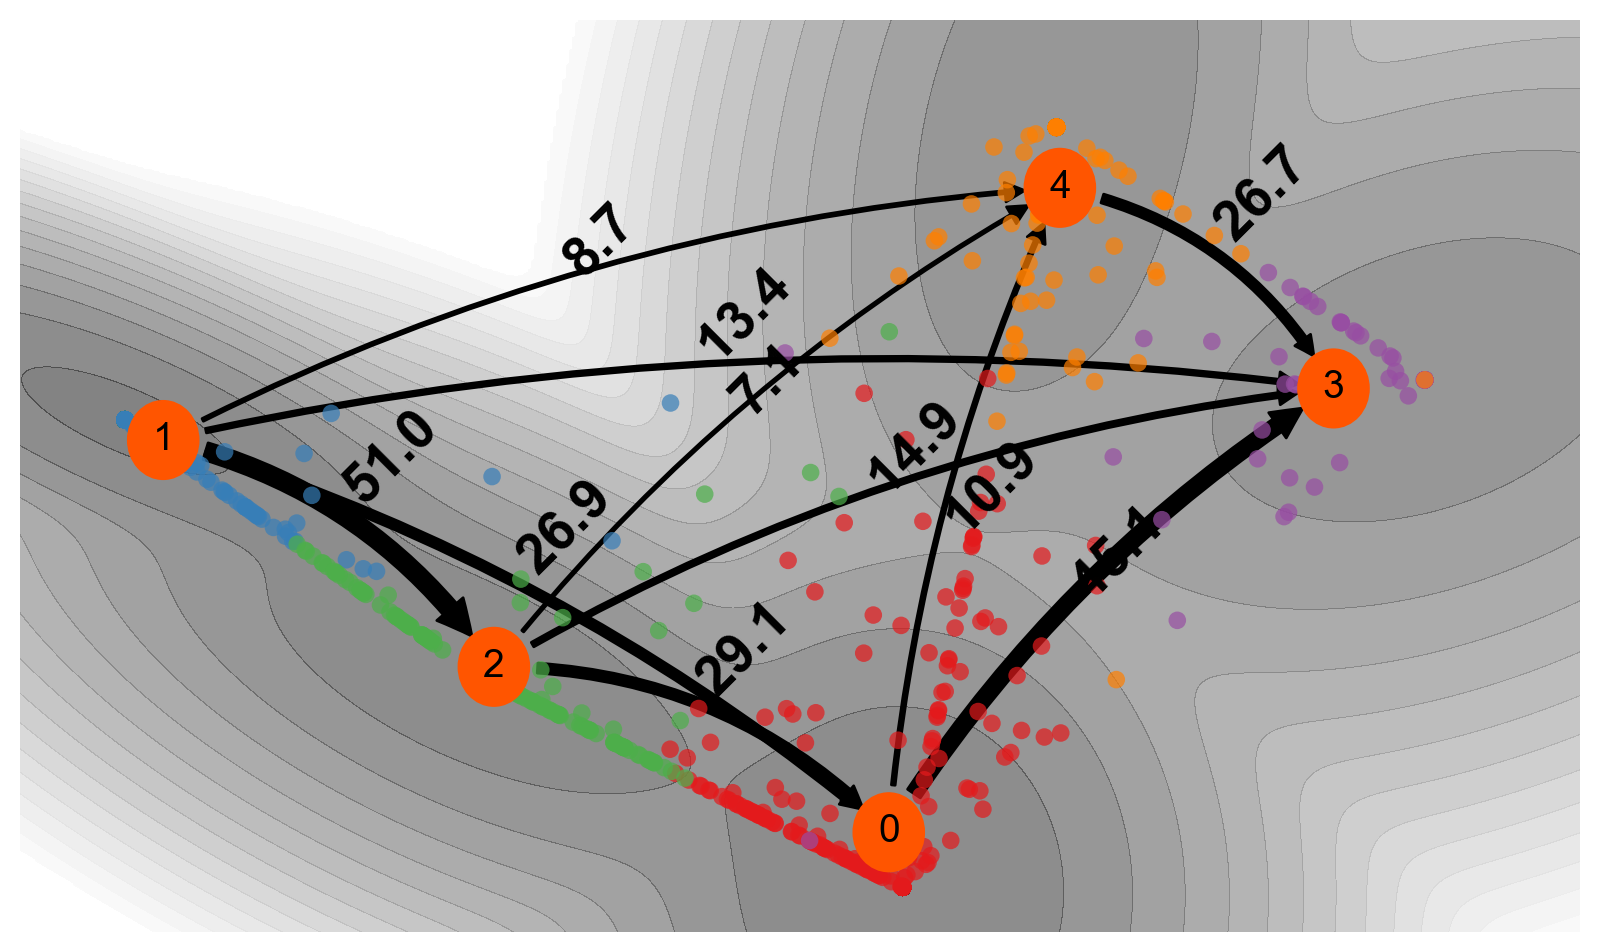

In [35]:
fig = plt.figure(figsize = (10,6))
pm.infer_lineage(adata_mu,si = 1,sf = 3, flux_fraction = 1, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"exit_v2_mppt_1_to_3_100.pdf")
plt.savefig(plotdir+"exit_v2_mppt_1_to_3_100.png")

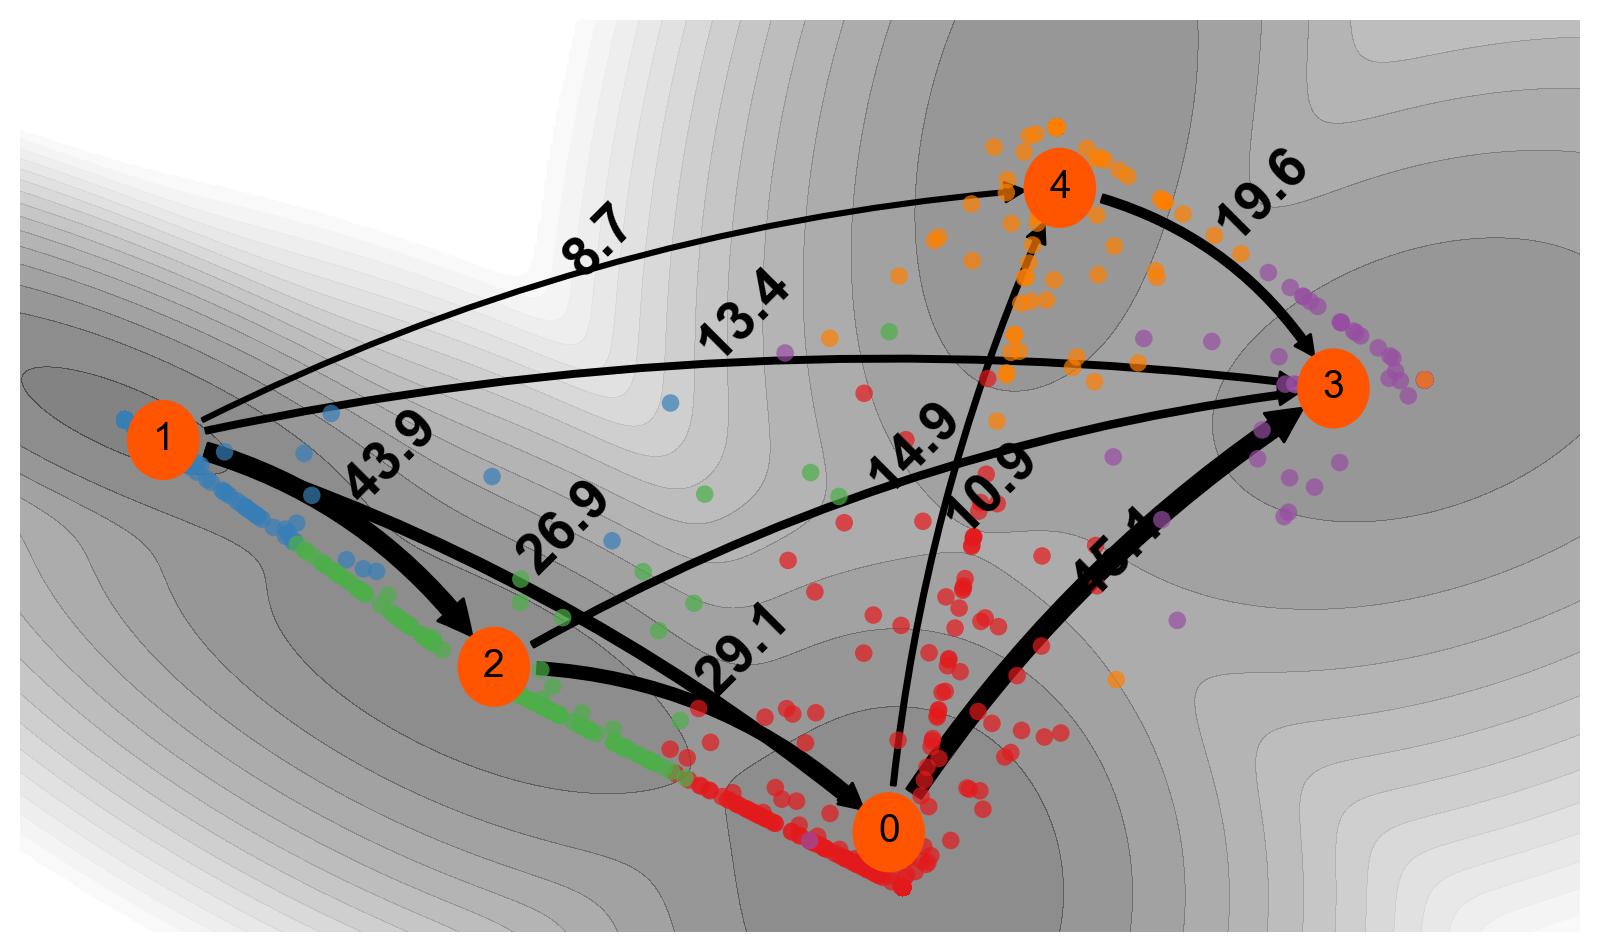

In [36]:
fig = plt.figure(figsize = (10,6))
pm.infer_lineage(adata_mu,si = 1,sf = 3, flux_fraction = 0.9, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"exit_v2_mppt_1_to_3_90.pdf")
plt.savefig(plotdir+"exit_v2_mppt_1_to_3_90.png")

MPPT 1 to 4

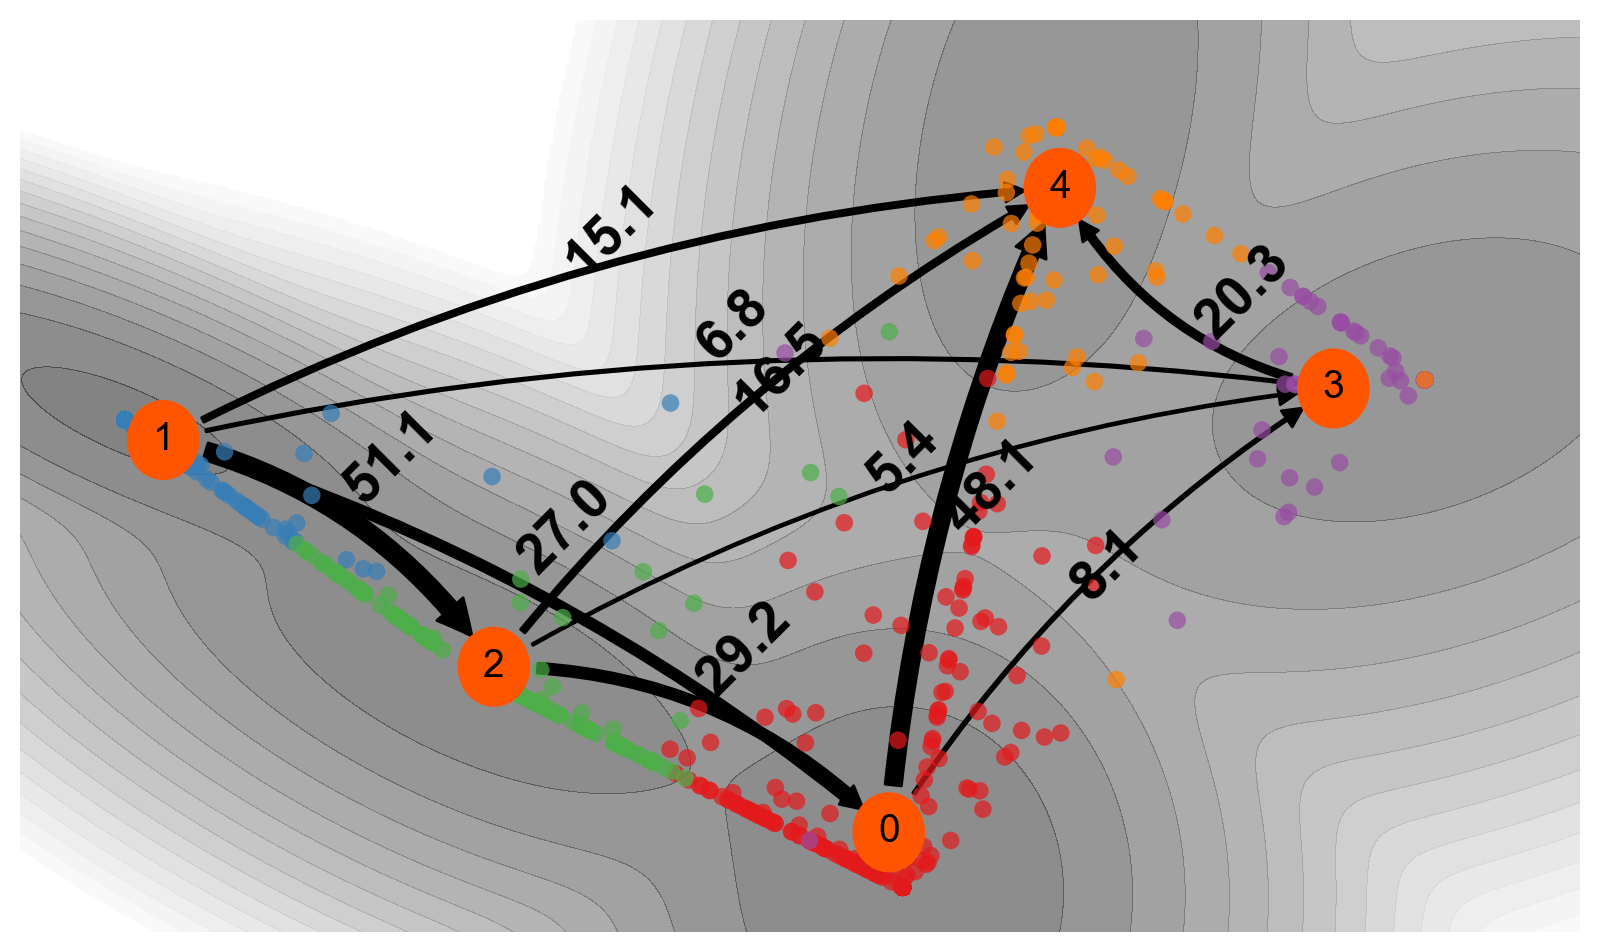

In [38]:
fig = plt.figure(figsize = (10,6))
pm.infer_lineage(adata_mu,si = 1,sf = 4, flux_fraction = 1, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"exit_v2_mppt_1_to_4_100.pdf")
plt.savefig(plotdir+"exit_v2_mppt_1_to_4_100.png")

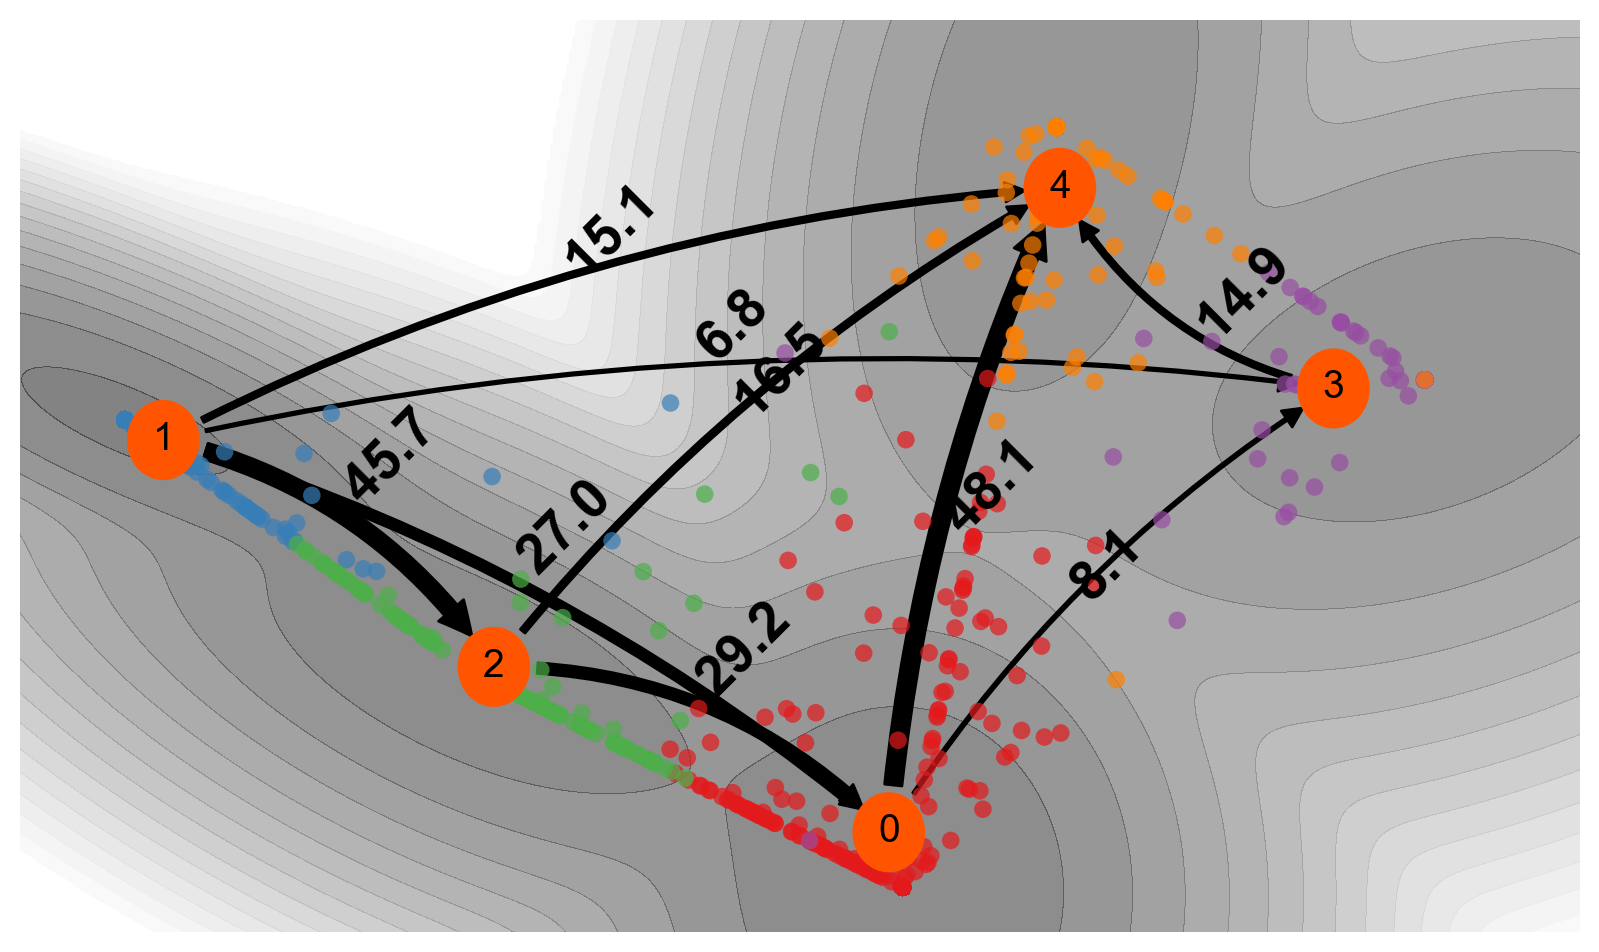

In [39]:
fig = plt.figure(figsize = (10,6))
pm.infer_lineage(adata_mu,si = 1,sf = 4, flux_fraction = 0.9, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"exit_v2_mppt_1_to_4_90.pdf")
plt.savefig(plotdir+"exit_v2_mppt_1_to_4_90.png")

MPPT 4 to 1

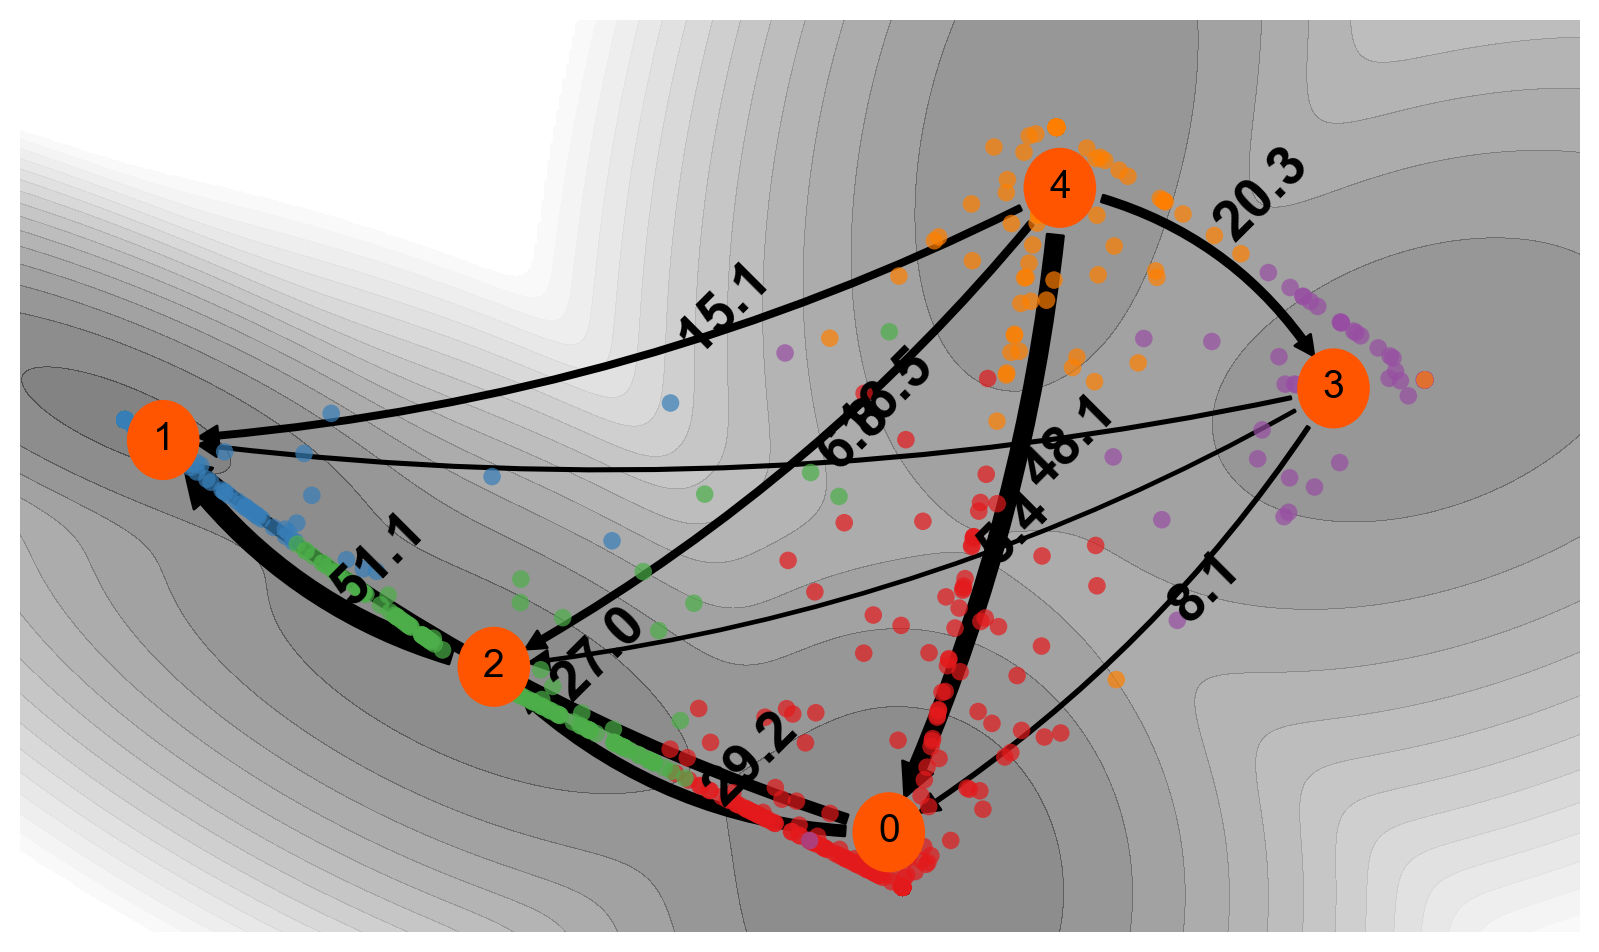

In [41]:
fig = plt.figure(figsize = (10,6))
pm.infer_lineage(adata_mu,si = 4,sf = 1, flux_fraction = 1, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"exit_v2_mppt_4_to_1_100.pdf")
plt.savefig(plotdir+"exit_v2_mppt_4_to_1_100.png")

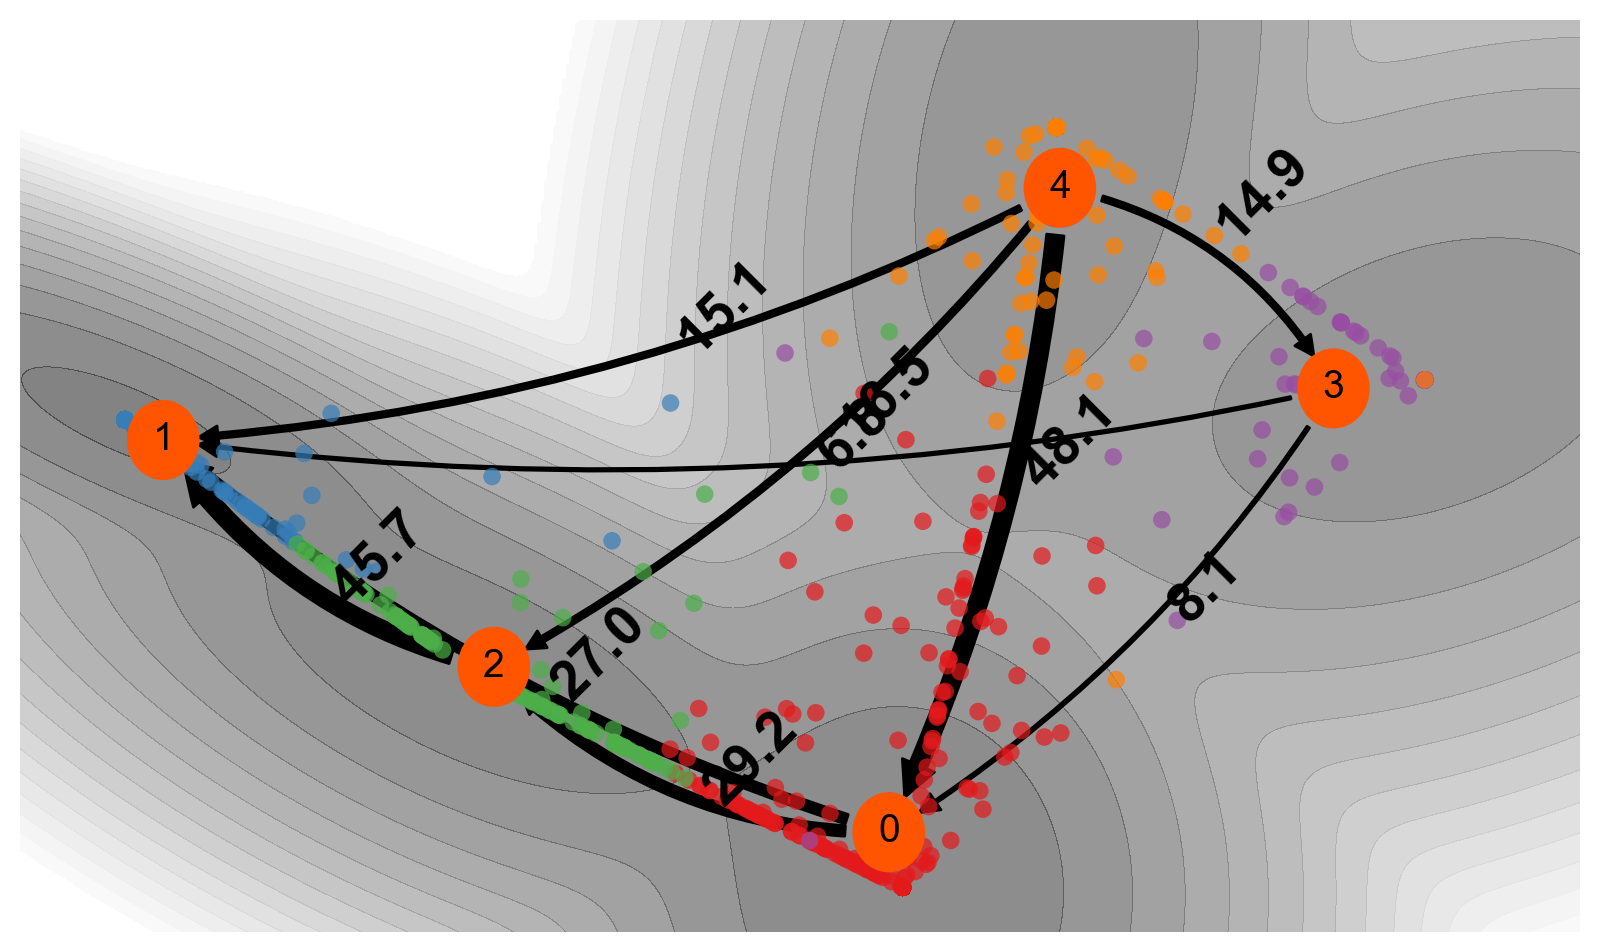

In [42]:
fig = plt.figure(figsize = (10,6))
pm.infer_lineage(adata_mu,si = 4,sf = 1, flux_fraction = 0.9, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"exit_v2_mppt_4_to_1_90.pdf")
plt.savefig(plotdir+"exit_v2_mppt_4_to_1_90.png")

MPPT 3 to 1

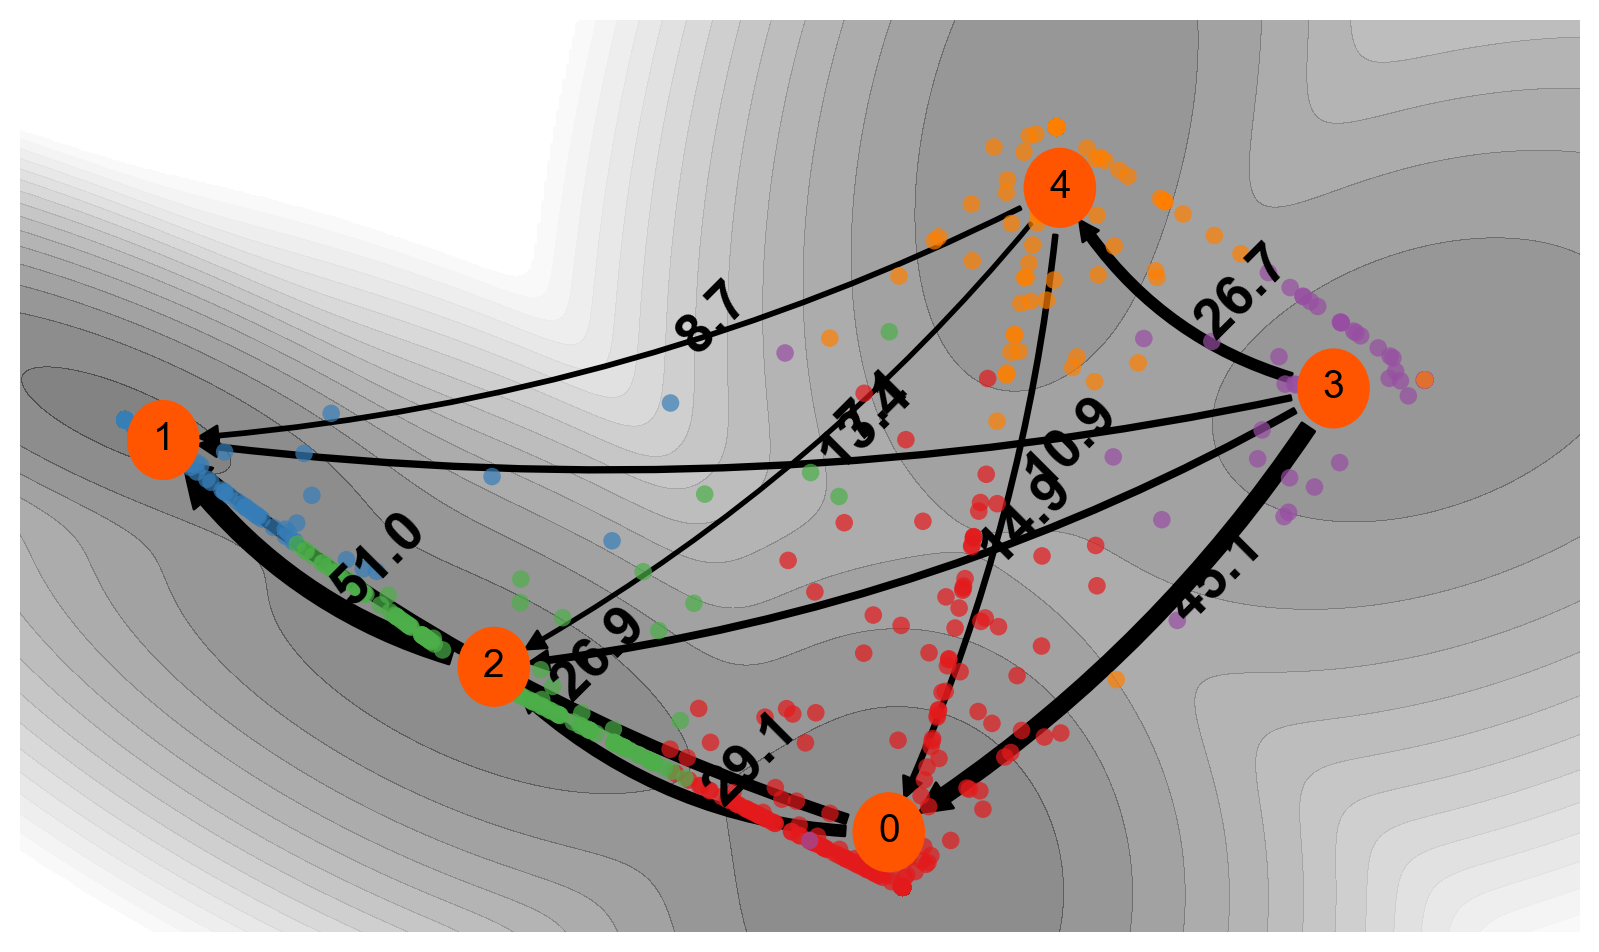

In [43]:
fig = plt.figure(figsize = (10,6))
pm.infer_lineage(adata_mu,si = 3,sf = 1, flux_fraction = 1, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"exit_v2_mppt_3_to_1_100.pdf")
plt.savefig(plotdir+"exit_v2_mppt_3_to_1_100.png")

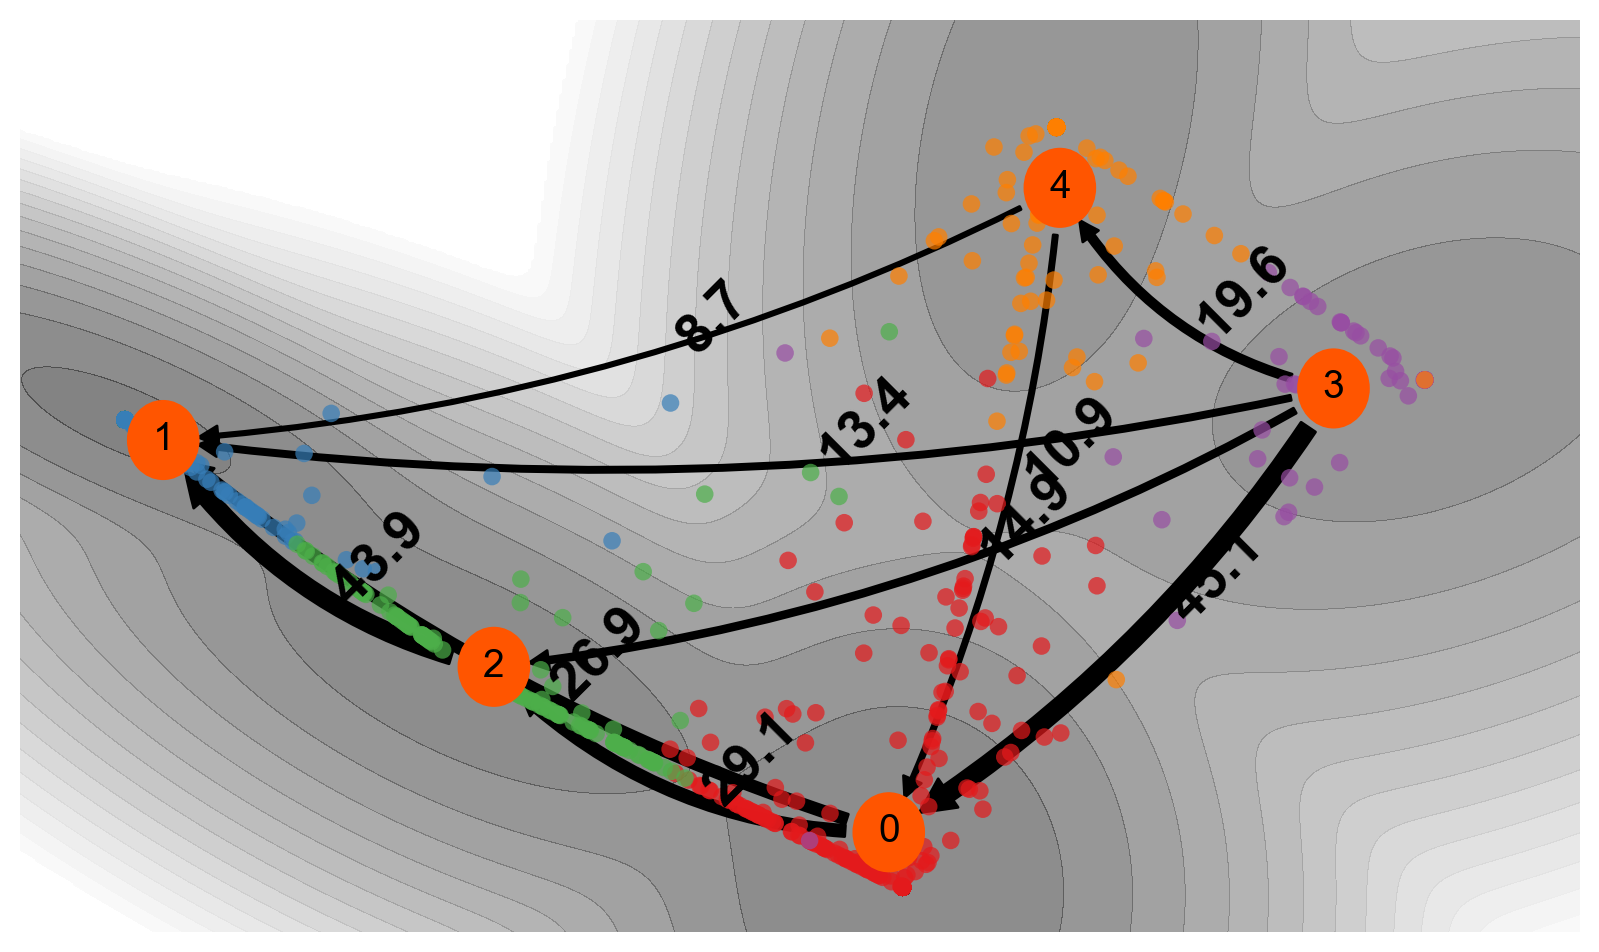

In [44]:
fig = plt.figure(figsize = (10,6))
pm.infer_lineage(adata_mu,si = 3,sf = 1, flux_fraction = 0.9, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"exit_v2_mppt_3_to_1_90.pdf")
plt.savefig(plotdir+"exit_v2_mppt_3_to_1_90.png")

MPPT 4 to 3

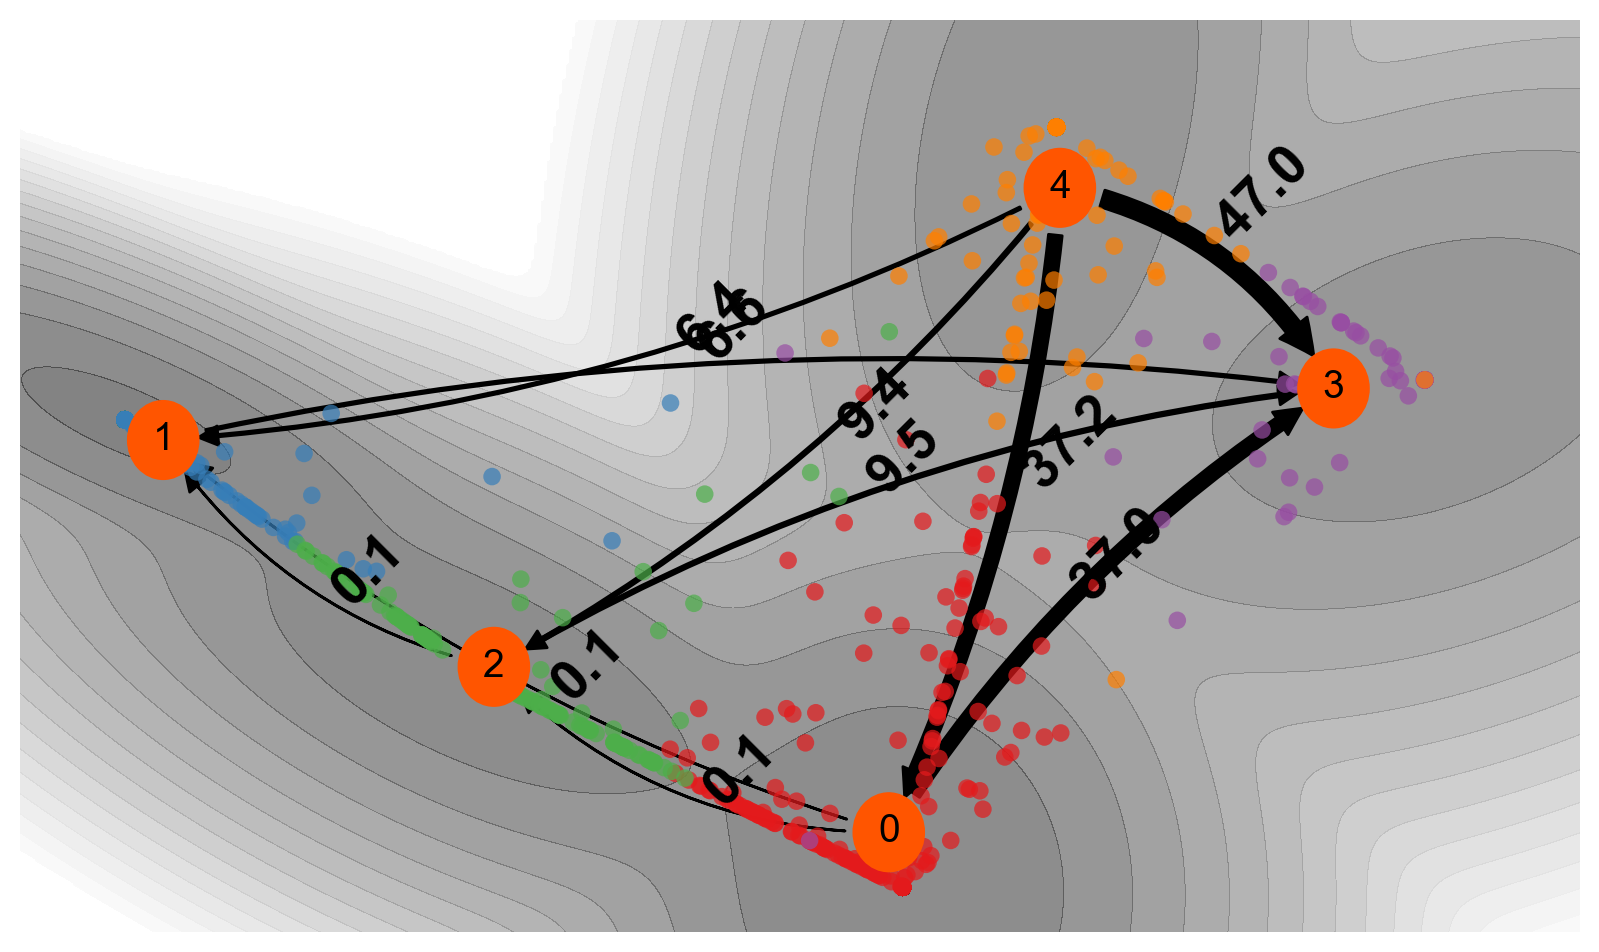

In [45]:
fig = plt.figure(figsize = (10,6))
pm.infer_lineage(adata_mu,si = 4,sf = 3, flux_fraction = 1, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"exit_v2_mppt_4_to_3_100.pdf")
plt.savefig(plotdir+"exit_v2_mppt_4_to_3_100.png")

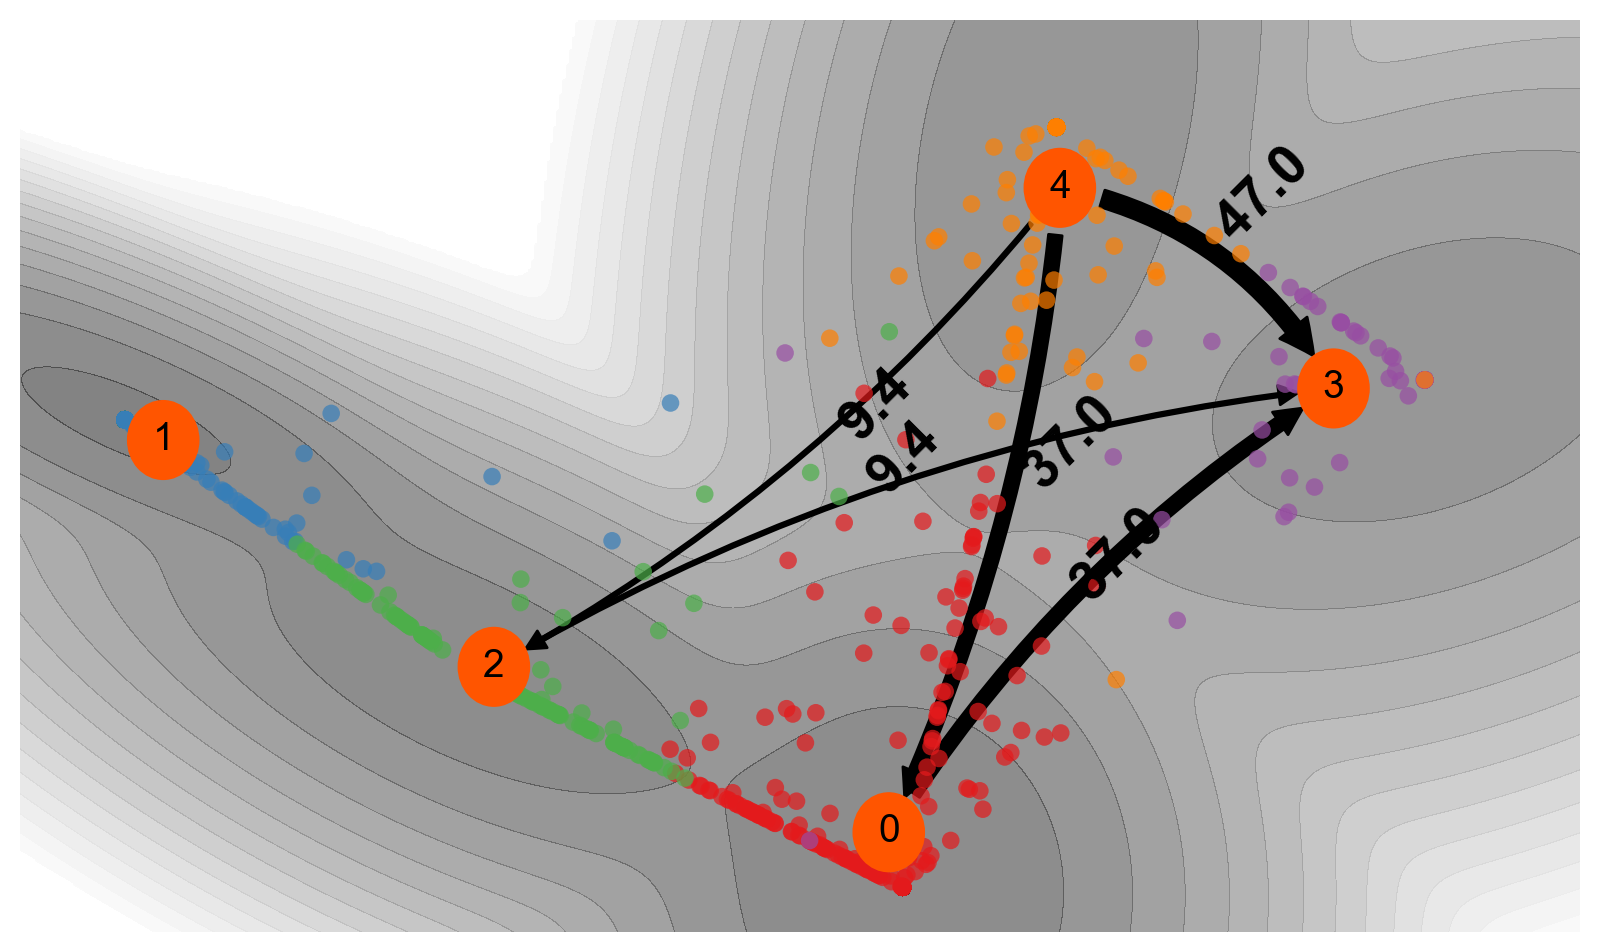

In [46]:
fig = plt.figure(figsize = (10,6))
pm.infer_lineage(adata_mu,si = 4,sf = 3, flux_fraction = 0.9, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"exit_v2_mppt_4_to_3_90.pdf")
plt.savefig(plotdir+"exit_v2_mppt_4_to_3_90.png")

MPPT 3 to 4

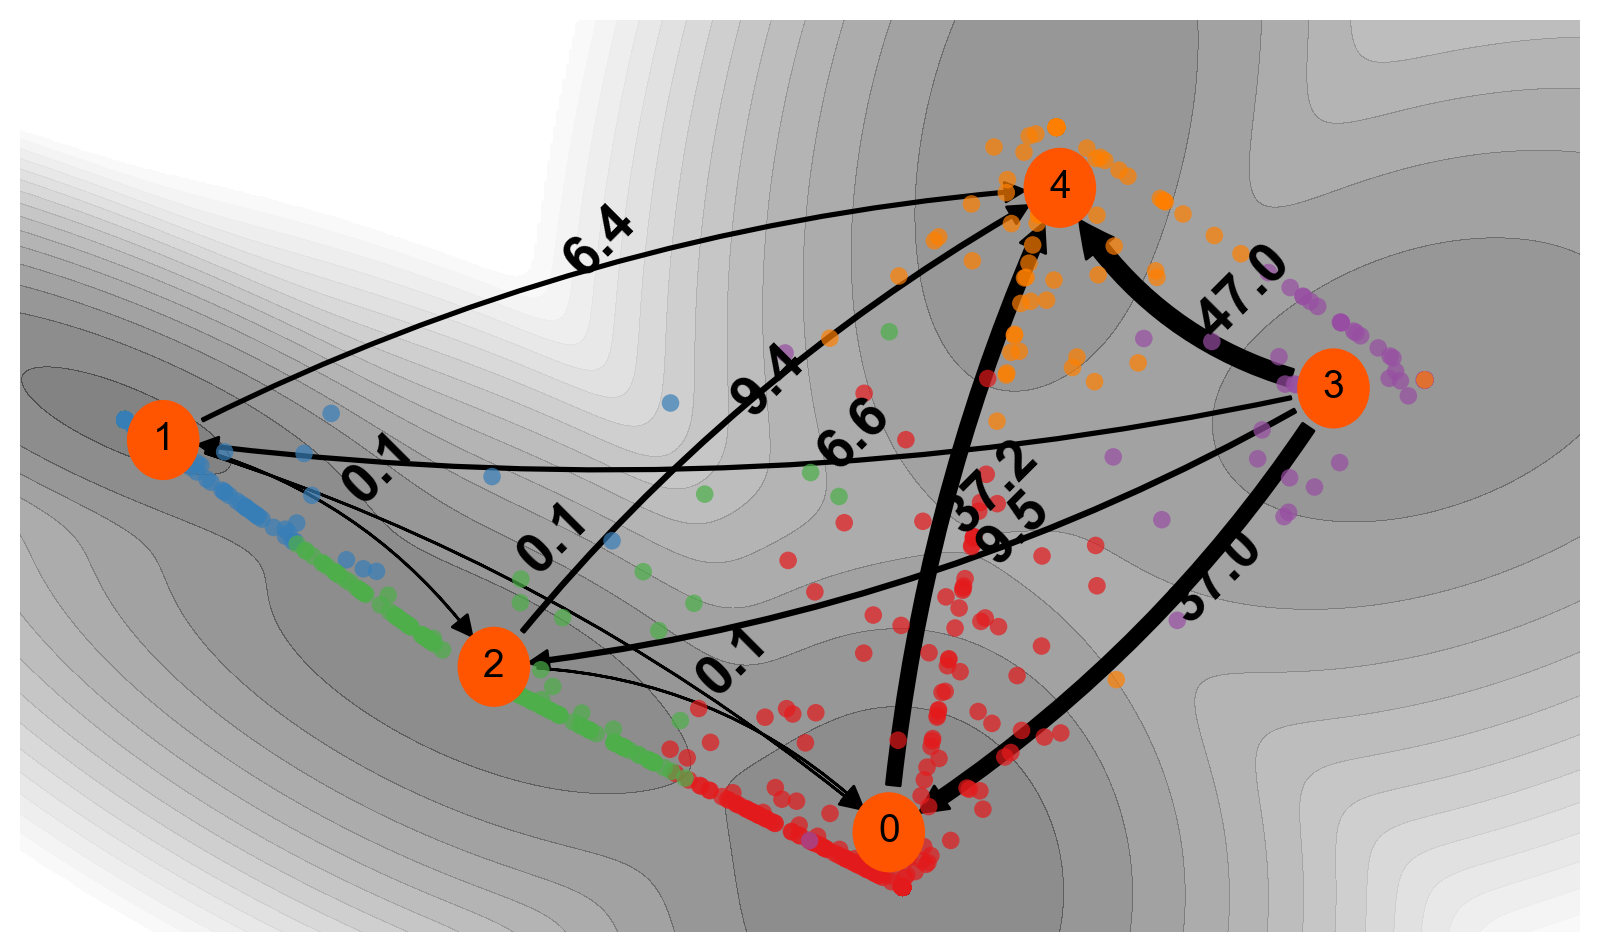

In [47]:
fig = plt.figure(figsize = (10,6))
pm.infer_lineage(adata_mu,si = 3,sf = 4, flux_fraction = 1, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"exit_v2_mppt_3_to_4_100.pdf")
plt.savefig(plotdir+"exit_v2_mppt_3_to_4_100.png")

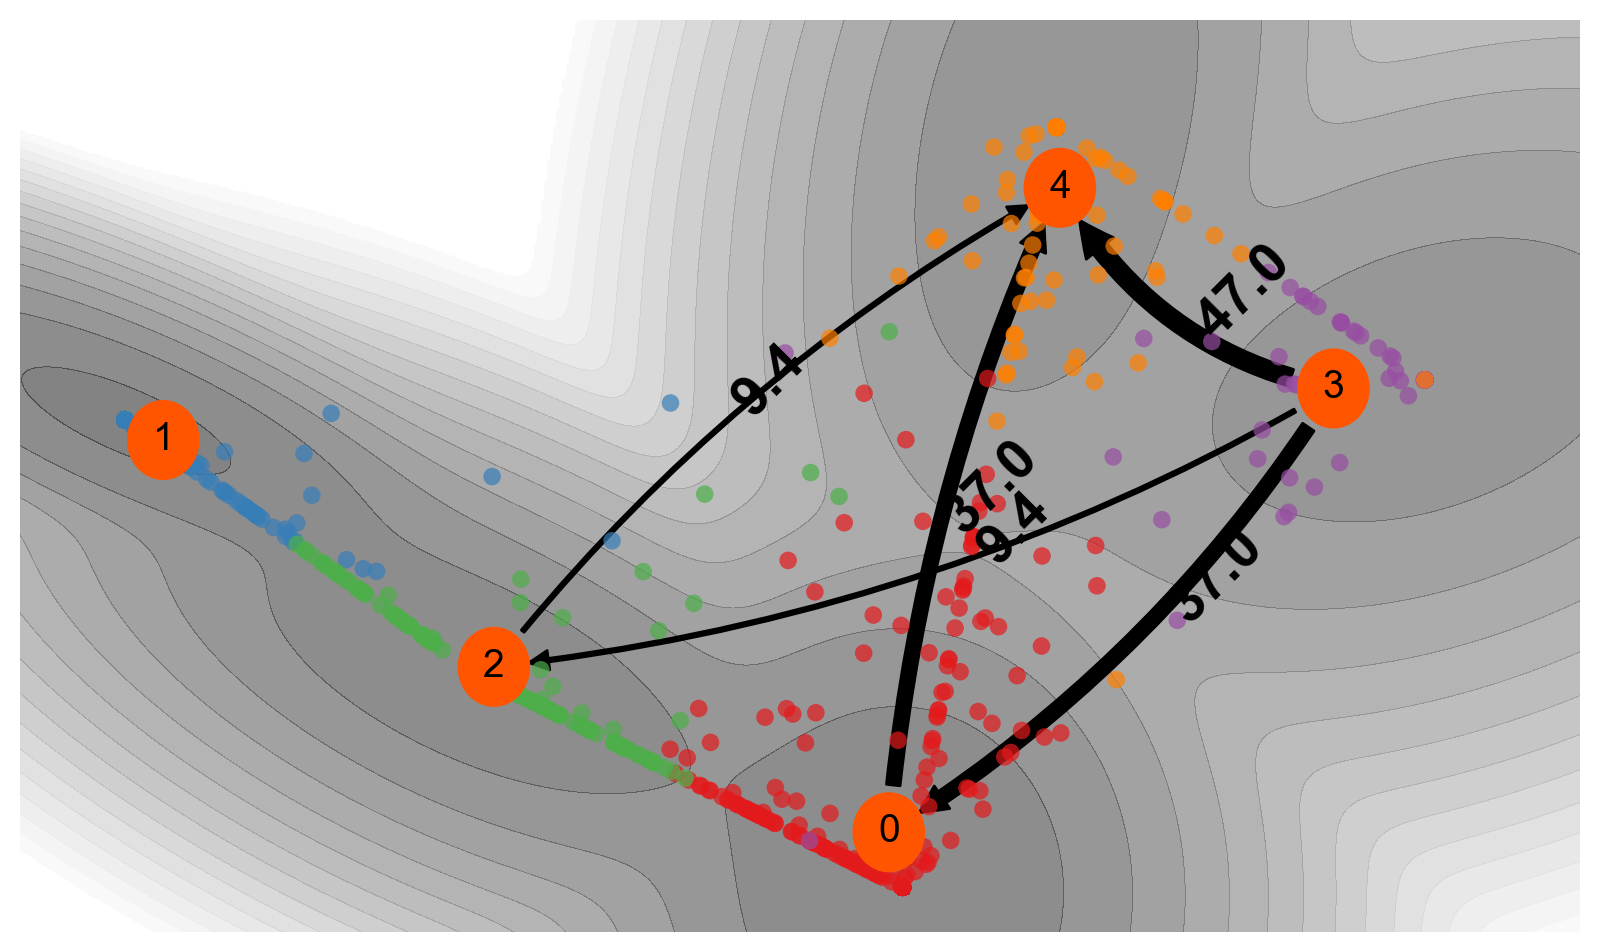

In [48]:
fig = plt.figure(figsize = (10,6))
pm.infer_lineage(adata_mu,si = 3,sf = 4, flux_fraction = 0.9, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"exit_v2_mppt_3_to_4_90.pdf")
plt.savefig(plotdir+"exit_v2_mppt_3_to_4_90.png")

In [37]:
adata_mu.obs['attractor'] = adata_mu.obs.attractor.astype('category')

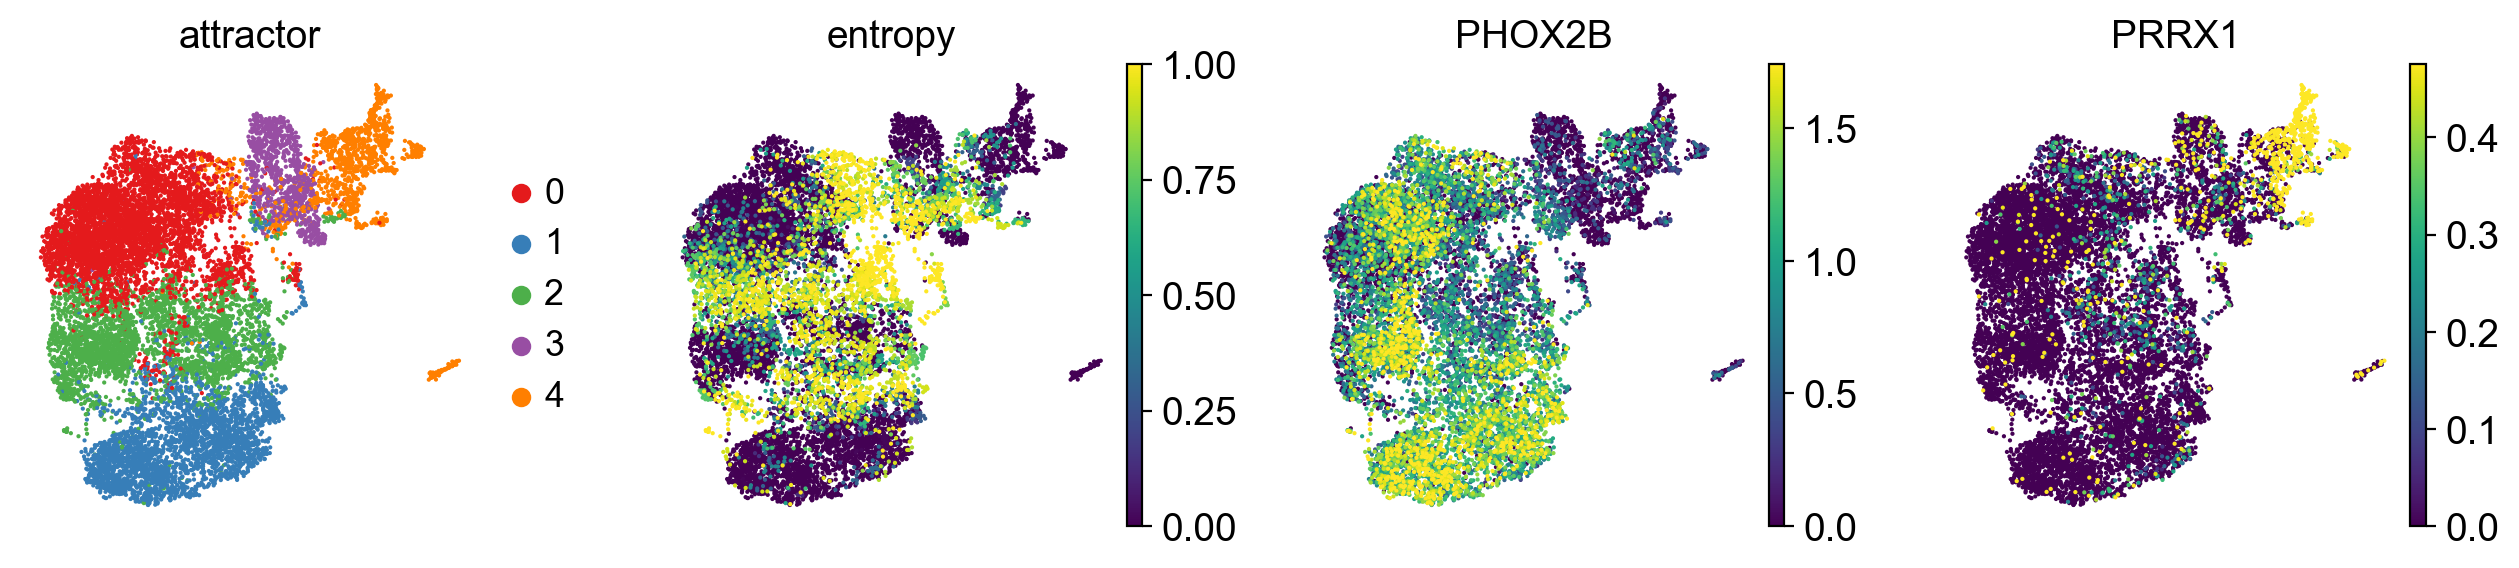

In [40]:
color_palette = sns.color_palette('Set1', 5)
sc.pl.umap(adata_mu, color = ['attractor', 'entropy', 'PHOX2B', 'PRRX1'], vmax = 'p95', palette = color_palette, show = False)
plt.savefig(plotdir+"exit_v2_umap_attractor_entropy.pdf")
plt.savefig(plotdir+"exit_v2_umap_attractor_entropy.png")

In [49]:
for keys in list(adata_mu.uns['da_out'].keys()):
    if type(adata_mu.uns['da_out'][keys]).__name__ == 'double':
        adata_mu.uns['da_out'][keys] = np.asarray(adata_mu.uns['da_out'][keys])    

for keys in list(adata_mu.uns['land'].keys()):
    if type(adata_mu.uns['land'][keys]).__name__ == 'double':
        adata_mu.uns['land'][keys] = np.asarray(adata_mu.uns['land'][keys])    

del adata_mu.uns['land']['model']

adata_mu.write(datadir+'exit_v2_mutrans.h5ad')

In [50]:
del adata_mu.uns['da_out']
del adata_mu.uns['land']

In [51]:
adata_mu.write_h5ad(
    datadir+"exit_v2_mutrans_mod.h5ad",
    compression = hdf5plugin.FILTERS["zstd"]
)

#### Violin plots

In [2]:
plotdir = "../../plots/exit_v2/"

In [3]:
adata_mu = sc.read(datadir+'exit_v2_mutrans.h5ad')
adata_mu.obs['attractor'] = adata_mu.obs.attractor.astype('category')
color_palette = sns.color_palette('Set1', 5)

c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [4]:
conditions = [
    adata_mu.obs['attractor'] == 0,
    adata_mu.obs['attractor'] == 1,
    adata_mu.obs['attractor'] == 2,
    adata_mu.obs['attractor'] == 3,
    adata_mu.obs['attractor'] == 4
]

outputs = [
    'I', 'II', 'III', 'V', 'IV'
]

In [5]:
adata_mu.obs['energy_rank'] = np.select(conditions, outputs)

In [6]:
energy_pal = {
    'I' : color_palette[0],
    'II' : color_palette[1],
    'III' : color_palette[2],
    'IV' : color_palette[4],
    'V' : color_palette[3]
}

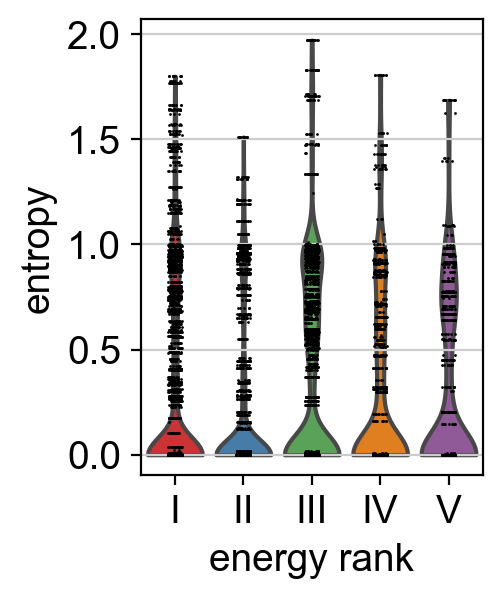

In [8]:
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(3, 3), facecolor='white')
sc.pl.violin(adata_mu, keys = 'entropy', groupby='energy_rank', show=False, palette = energy_pal)
plt.savefig(plotdir+"exit_v2_violin_attractor_entropy_ranked.pdf")
plt.savefig(plotdir+"exit_v2_violin_attractor_entropy_ranked.png")

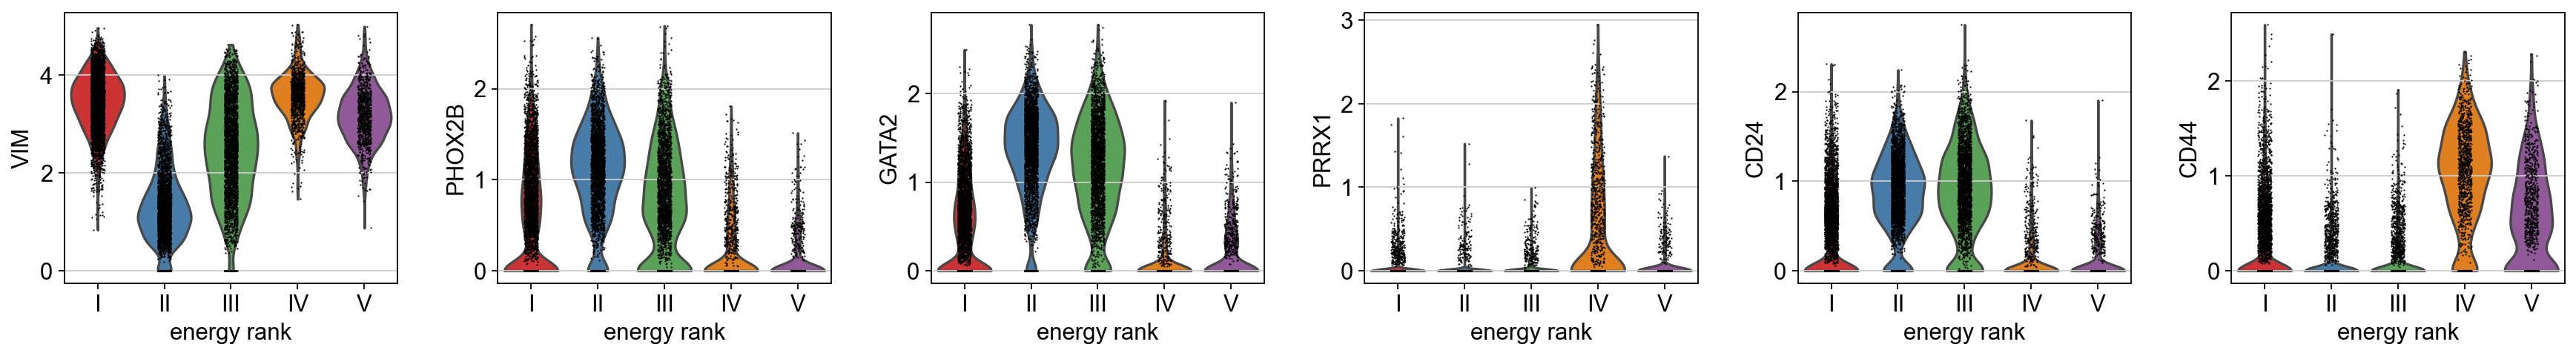

In [9]:
sc.settings.set_figure_params(frameon=False,figsize=(4, 3))
sc.pl.violin(adata_mu, keys = ['VIM','PHOX2B','GATA2','PRRX1','CD24','CD44'], groupby = 'energy_rank', show=False, palette = energy_pal)
plt.savefig(plotdir+"exit_v2_violin_markers_ranked.pdf")
plt.savefig(plotdir+"exit_v2_violin_markers_ranked.png")

In [10]:
adata_mu.write_h5ad(
    datadir+"exit_v2_mutrans_ranked.h5ad",
    compression=hdf5plugin.FILTERS["zstd"]
)

#### Hybrid signature

In [2]:
plotdir = "../../plots/exit_v2/"
adata_mu = sc.read(datadir+'exit_v2_mutrans_ranked.h5ad')

c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [3]:
hyb_sig = pd.read_csv(datadir+"method2_dge.csv")

In [4]:
hyb_list = hyb_sig['gene'].tolist()

In [5]:
sc.tl.score_genes(adata_mu, gene_list=hyb_list, ctrl_size=len(hyb_list), score_name="HYB.Sig")

In [6]:
color_palette = sns.color_palette('Set1', 5)
energy_pal = {
    'I' : color_palette[0],
    'II' : color_palette[1],
    'III' : color_palette[2],
    'IV' : color_palette[4],
    'V' : color_palette[3]
}

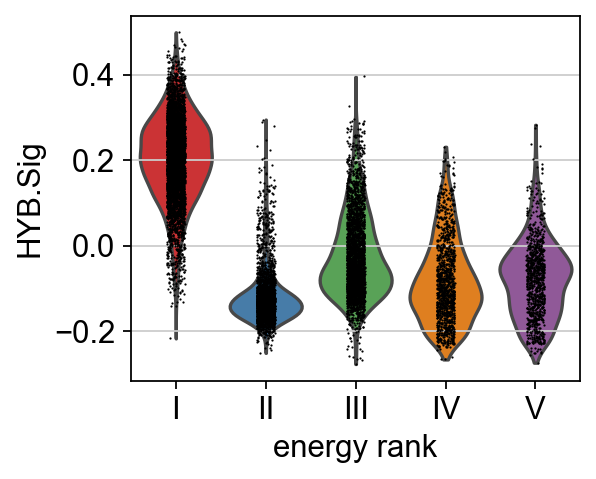

In [7]:
sc.settings.set_figure_params(frameon=False,figsize=(4, 3))
sc.pl.violin(adata_mu, keys = 'HYB.Sig', groupby = 'energy_rank', show=False, palette = energy_pal)
plt.savefig(plotdir+"exit_v2_violin_hyb_ranked.pdf")
plt.savefig(plotdir+"exit_v2_violin_hyb_ranked.png")